In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

import torch
print(f"PyTorch GPU 사용 가능: {torch.cuda.is_available()}")
print(f"GPU 이름: {torch.cuda.get_device_name(0)}")
print(f"GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Thu Nov 27 08:06:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# 필요한 라이브러리 설치

# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil
from tqdm import tqdm
import random
import zipfile
from concurrent.futures import ThreadPoolExecutor
from functools import partial

Mounted at /content/drive


In [ ]:
# 구글 드라이브의 데이터 경로
DRIVE_REAL_DIR = '/content/drive/MyDrive/frames'
DRIVE_FAKE_ZIP = '/content/drive/MyDrive/Colab Notebooks/fake.zip'

In [ ]:
# 최종 데이터셋 폴더 구조 생성
TRAIN_DIR = '/content/dataset/train/normal'
TEST_NORMAL_DIR = '/content/dataset/test/normal'
TEST_FAKE_DIR = '/content/dataset/test/fake'
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(TEST_NORMAL_DIR, exist_ok=True)
os.makedirs(TEST_FAKE_DIR, exist_ok=True)

def copy_file(src_dst_tuple):
    """병렬 처리를 위한 파일 복사 함수"""
    src, dst = src_dst_tuple
    try:
        shutil.copy2(src, dst)
        return True
    except Exception as e:
        print(f"Error copying {src}: {e}")
        return False

def parallel_copy(file_list, desc="파일 복사"):
    """병렬로 파일 복사"""
    with ThreadPoolExecutor(max_workers=8) as executor:
        list(tqdm(
            executor.map(copy_file, file_list),
            total=len(file_list),
            desc=desc
        ))

In [ ]:
print("1. Real 데이터 처리 (일반 폴더)")
# Real 데이터 파일 수집 - ZIP 압축 해제 없이 바로 접근
real_files = [f for f in os.listdir(DRIVE_REAL_DIR)
              if os.path.isfile(os.path.join(DRIVE_REAL_DIR, f))
              and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"- 발견된 Real 이미지: {len(real_files)}개")

# Real 데이터: train 80%, test 20%로 분할
random.shuffle(real_files)
split_idx = int(len(real_files) * 0.8)
train_files = real_files[:split_idx]
test_files = real_files[split_idx:]

print(f"- 훈련용 이미지: {len(train_files)}개")
print(f"- 테스트용 이미지: {len(test_files)}개")

# 병렬 복사 - 훈련 데이터
train_copy_list = [(os.path.join(DRIVE_REAL_DIR, f), os.path.join(TRAIN_DIR, f))
                   for f in train_files]
parallel_copy(train_copy_list, "훈련 데이터 복사 (병렬)")

# 병렬 복사 - 테스트 정상 데이터
test_copy_list = [(os.path.join(DRIVE_REAL_DIR, f), os.path.join(TEST_NORMAL_DIR, f))
                  for f in test_files]
parallel_copy(test_copy_list, "테스트 정상 데이터 복사 (병렬)")

print("\n2. Fake 데이터 ZIP 압축 해제")
temp_fake_dir = '/content/temp_fake'
with zipfile.ZipFile(DRIVE_FAKE_ZIP, 'r') as zip_ref:
    zip_ref.extractall(temp_fake_dir)
print("- Fake 데이터 압축 해제 완료")

# Fake 데이터 파일 수집
fake_data_dir = os.path.join(temp_fake_dir, 'fake')
fake_files = [f for f in os.listdir(fake_data_dir)
              if os.path.isfile(os.path.join(fake_data_dir, f))
              and f.lower().endswith(('.png', '.jpg', '.jpeg'))]

print(f"- 발견된 Fake 이미지: {len(fake_files)}개")

# 병렬 복사 - 테스트 딥페이크 데이터
fake_copy_list = [(os.path.join(fake_data_dir, f), os.path.join(TEST_FAKE_DIR, f))
                  for f in fake_files]
parallel_copy(fake_copy_list, "테스트 딥페이크 데이터 복사 (병렬)")

print("\n3. 임시 폴더 정리")
shutil.rmtree(temp_fake_dir)
print("- 임시 폴더 삭제 완료")

print("\n데이터 준비 완료.")
print(f"- 훈련 데이터: {len(os.listdir(TRAIN_DIR))}개")
print(f"- 테스트 정상: {len(os.listdir(TEST_NORMAL_DIR))}개")
print(f"- 테스트 딥페이크: {len(os.listdir(TEST_FAKE_DIR))}개")

1. Real 데이터 처리 (일반 폴더)
- 발견된 Real 이미지: 5892개
- 훈련용 이미지: 4713개
- 테스트용 이미지: 1179개


테스트 정상 데이터 복사 (병렬): 100%|██████████| 1179/1179 [00:01<00:00, 679.07it/s]



2. Fake 데이터 ZIP 압축 해제
- Fake 데이터 압축 해제 완료
- 발견된 Fake 이미지: 1441개


테스트 딥페이크 데이터 복사 (병렬): 100%|██████████| 1441/1441 [00:00<00:00, 3211.50it/s]



3. 임시 폴더 정리
- 임시 폴더 삭제 완료

데이터 준비 완료.
- 훈련 데이터: 4713개
- 테스트 정상: 1179개
- 테스트 딥페이크: 1441개


In [ ]:
# 라이브러리 임포트 및 설정

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# torchvision import (오류 방지)
try:
    from torchvision import transforms
    print("torchvision import 성공")
except AttributeError as e:
    print("torchvision import 오류")
    print("해결: 런타임 → 런타임 다시 시작")
    print("또는: !pip install torch torchvision --upgrade")
    raise

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

torchvision import 성공


In [ ]:
# 설정(Config)

class Config:
    TRAIN_DATA_PATH = '/content/dataset/train'
    TEST_DATA_PATH = '/content/dataset/test'
    IMAGE_SIZE = 64
    BATCH_SIZE = 32
    LATENT_DIM = 128
    EPOCHS = 100
    LR_G = 0.0002
    LR_D = 0.0001
    BETA1 = 0.5
    BETA2 = 0.999
    W_ADV = 1
    W_CON = 50
    W_ENC = 1
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
print(f"사용 장치: {config.DEVICE}")

사용 장치: cuda


In [ ]:
# 데이터셋 정의

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        if 'train' in root_dir:
            normal_dir = os.path.join(root_dir, 'normal')
            for fname in os.listdir(normal_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(normal_dir, fname))
                    self.labels.append(0)
        else:
            normal_dir = os.path.join(root_dir, 'normal')
            fake_dir = os.path.join(root_dir, 'fake')
            for fname in os.listdir(normal_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(normal_dir, fname))
                    self.labels.append(0)
            for fname in os.listdir(fake_dir):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(fake_dir, fname))
                    self.labels.append(1)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label, img_path

transform = transforms.Compose([
    transforms.Resize((config.IMAGE_SIZE, config.IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = ImageDataset(root_dir=config.TRAIN_DATA_PATH, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

test_dataset = ImageDataset(root_dir=config.TEST_DATA_PATH, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=2)

print(f"훈련 데이터 개수: {len(train_dataset)}")
print(f"테스트 데이터 개수: {len(test_dataset)}")
print(f"배치 개수: {len(train_loader)}")

훈련 데이터 개수: 4713
테스트 데이터 개수: 2620
배치 개수: 147


In [ ]:
# GANomaly 모델 정의

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder 1: x -> z
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, config.LATENT_DIM, 4, 1, 0, bias=False),
        )

        # Decoder: z -> x'
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(config.LATENT_DIM, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

        # Encoder 2: x' -> z'
        self.encoder2 = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, config.LATENT_DIM, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        z = self.encoder1(x)
        x_hat = self.decoder(z)
        z_hat = self.encoder2(x_hat)
        return x_hat, z, z_hat

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.classifier = nn.Sequential(
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        )

    def forward(self, x):
        features = self.features(x)
        classifier = self.classifier(features)
        classifier = classifier.view(-1)
        return classifier, features

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# 모델 생성 및 초기화

netG = Generator().to(config.DEVICE)
netD = Discriminator().to(config.DEVICE)

netG.apply(weights_init)
netD.apply(weights_init)

print("모델 구조:")
print(f"Generator 파라미터 수: {sum(p.numel() for p in netG.parameters()):,}")
print(f"Discriminator 파라미터 수: {sum(p.numel() for p in netD.parameters()):,}")

모델 구조:
Generator 파라미터 수: 11,417,984
Discriminator 파라미터 수: 2,765,568


In [ ]:
# Loss functions 및 Optimizers

criterion_bce = nn.BCEWithLogitsLoss()
criterion_l1 = nn.L1Loss()
criterion_l2 = nn.MSELoss()

optimizerG = optim.Adam(netG.parameters(), lr=config.LR_G, betas=(config.BETA1, config.BETA2))
optimizerD = optim.Adam(netD.parameters(), lr=config.LR_D, betas=(config.BETA1, config.BETA2))

schedulerG = optim.lr_scheduler.ExponentialLR(optimizerG, gamma=0.99)
schedulerD = optim.lr_scheduler.ExponentialLR(optimizerD, gamma=0.99)

In [ ]:
# 학습

print("\n훈련 시작")

loss_history = {'D': [], 'G': [], 'G_adv': [], 'G_con': [], 'G_enc': []}

for epoch in range(config.EPOCHS):
    netG.train()
    netD.train()

    epoch_loss_d = 0
    epoch_loss_g = 0
    epoch_loss_g_adv = 0
    epoch_loss_g_con = 0
    epoch_loss_g_enc = 0

    for i, (real_images, _, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS}")):
        batch_size = real_images.size(0)
        real_images = real_images.to(config.DEVICE)

        # Real/Fake labels with label smoothing
        real_label = torch.ones(batch_size, device=config.DEVICE) * 0.9
        fake_label = torch.zeros(batch_size, device=config.DEVICE) + 0.1

        # Update D network
        netD.zero_grad()
        pred_real, _ = netD(real_images)
        errD_real = criterion_bce(pred_real, real_label)

        fake_images, _, _ = netG(real_images)
        pred_fake, _ = netD(fake_images.detach())
        errD_fake = criterion_bce(pred_fake, fake_label)

        errD = (errD_real + errD_fake) * 0.5
        errD.backward()
        torch.nn.utils.clip_grad_norm_(netD.parameters(), max_norm=3.0)
        optimizerD.step()

        # Update G network
        netG.zero_grad()
        fake_images, latent_i, latent_o = netG(real_images)

        pred_fake, feat_fake = netD(fake_images)
        _, feat_real = netD(real_images)
        errG_adv = criterion_bce(pred_fake, torch.ones(batch_size, device=config.DEVICE))
        errG_con = criterion_l1(fake_images, real_images)
        errG_enc = criterion_l2(latent_o, latent_i)
        errG_feat = criterion_l1(feat_fake, feat_real.detach())

        errG = (config.W_ADV * errG_adv +
                config.W_CON * errG_con +
                config.W_ENC * errG_enc +
                5.0 * errG_feat)

        errG.backward()
        torch.nn.utils.clip_grad_norm_(netG.parameters(), max_norm=10.0)
        optimizerG.step()

        epoch_loss_d += errD.item()
        epoch_loss_g += errG.item()
        epoch_loss_g_adv += errG_adv.item()
        epoch_loss_g_con += errG_con.item()
        epoch_loss_g_enc += errG_enc.item()

    num_batches = len(train_loader)
    epoch_loss_d /= num_batches
    epoch_loss_g /= num_batches
    epoch_loss_g_adv /= num_batches
    epoch_loss_g_con /= num_batches
    epoch_loss_g_enc /= num_batches

    loss_history['D'].append(epoch_loss_d)
    loss_history['G'].append(epoch_loss_g)
    loss_history['G_adv'].append(epoch_loss_g_adv)
    loss_history['G_con'].append(epoch_loss_g_con)
    loss_history['G_enc'].append(epoch_loss_g_enc)

    schedulerG.step()
    schedulerD.step()

    current_lr_g = optimizerG.param_groups[0]['lr']
    current_lr_d = optimizerD.param_groups[0]['lr']
    print(f"[{epoch+1}/{config.EPOCHS}] "
          f"D: {epoch_loss_d:.4f} | "
          f"G: {epoch_loss_g:.4f} "
          f"(adv: {epoch_loss_g_adv:.4f}, con: {epoch_loss_g_con:.4f}, enc: {epoch_loss_g_enc:.4f}) | "
          f"LR_G: {current_lr_g:.6f}, LR_D: {current_lr_d:.6f}")

print("훈련 완료")


훈련 시작


Epoch 1/100: 100%|██████████| 147/147 [00:11<00:00, 12.56it/s]


[1/100] D: 1.8042 | G: 19.3668 (adv: 1.1901, con: 0.3136, enc: 0.8451) | LR_G: 0.000198, LR_D: 0.000099


Epoch 2/100: 100%|██████████| 147/147 [00:10<00:00, 14.38it/s]


[2/100] D: 0.6903 | G: 12.0332 (adv: 1.0861, con: 0.1960, enc: 0.2973) | LR_G: 0.000196, LR_D: 0.000098


Epoch 3/100: 100%|██████████| 147/147 [00:10<00:00, 14.29it/s]


[3/100] D: 0.7131 | G: 10.5191 (adv: 1.0113, con: 0.1702, enc: 0.2451) | LR_G: 0.000194, LR_D: 0.000097


Epoch 4/100: 100%|██████████| 147/147 [00:10<00:00, 14.09it/s]


[4/100] D: 0.7128 | G: 9.8016 (adv: 0.9799, con: 0.1573, enc: 0.2162) | LR_G: 0.000192, LR_D: 0.000096


Epoch 5/100: 100%|██████████| 147/147 [00:10<00:00, 13.94it/s]


[5/100] D: 0.7147 | G: 9.2584 (adv: 0.9335, con: 0.1480, enc: 0.1947) | LR_G: 0.000190, LR_D: 0.000095


Epoch 6/100: 100%|██████████| 147/147 [00:10<00:00, 13.82it/s]


[6/100] D: 0.7174 | G: 8.7778 (adv: 0.9079, con: 0.1392, enc: 0.1898) | LR_G: 0.000188, LR_D: 0.000094


Epoch 7/100: 100%|██████████| 147/147 [00:10<00:00, 13.62it/s]


[7/100] D: 0.7061 | G: 8.4570 (adv: 0.9041, con: 0.1330, enc: 0.1752) | LR_G: 0.000186, LR_D: 0.000093


Epoch 8/100: 100%|██████████| 147/147 [00:10<00:00, 13.44it/s]


[8/100] D: 0.7050 | G: 8.1804 (adv: 0.8950, con: 0.1280, enc: 0.1650) | LR_G: 0.000185, LR_D: 0.000092


Epoch 9/100: 100%|██████████| 147/147 [00:11<00:00, 13.27it/s]


[9/100] D: 0.7002 | G: 7.9351 (adv: 0.8761, con: 0.1237, enc: 0.1517) | LR_G: 0.000183, LR_D: 0.000091


Epoch 10/100: 100%|██████████| 147/147 [00:11<00:00, 13.09it/s]


[10/100] D: 0.6981 | G: 7.7652 (adv: 0.8718, con: 0.1207, enc: 0.1506) | LR_G: 0.000181, LR_D: 0.000090


Epoch 11/100: 100%|██████████| 147/147 [00:11<00:00, 12.97it/s]


[11/100] D: 0.7024 | G: 7.6061 (adv: 0.8818, con: 0.1171, enc: 0.1443) | LR_G: 0.000179, LR_D: 0.000090


Epoch 12/100: 100%|██████████| 147/147 [00:11<00:00, 13.08it/s]


[12/100] D: 0.6982 | G: 7.5421 (adv: 0.8795, con: 0.1158, enc: 0.1426) | LR_G: 0.000177, LR_D: 0.000089


Epoch 13/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[13/100] D: 0.6967 | G: 7.3949 (adv: 0.8584, con: 0.1136, enc: 0.1320) | LR_G: 0.000176, LR_D: 0.000088


Epoch 14/100: 100%|██████████| 147/147 [00:11<00:00, 13.28it/s]


[14/100] D: 0.6934 | G: 7.3600 (adv: 0.8849, con: 0.1119, enc: 0.1365) | LR_G: 0.000174, LR_D: 0.000087


Epoch 15/100: 100%|██████████| 147/147 [00:11<00:00, 13.34it/s]


[15/100] D: 0.6918 | G: 7.2682 (adv: 0.8799, con: 0.1101, enc: 0.1293) | LR_G: 0.000172, LR_D: 0.000086


Epoch 16/100: 100%|██████████| 147/147 [00:11<00:00, 13.29it/s]


[16/100] D: 0.6882 | G: 7.1872 (adv: 0.8653, con: 0.1085, enc: 0.1268) | LR_G: 0.000170, LR_D: 0.000085


Epoch 17/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[17/100] D: 0.6865 | G: 7.0651 (adv: 0.8634, con: 0.1059, enc: 0.1289) | LR_G: 0.000169, LR_D: 0.000084


Epoch 18/100: 100%|██████████| 147/147 [00:11<00:00, 13.14it/s]


[18/100] D: 0.6892 | G: 7.0697 (adv: 0.8698, con: 0.1058, enc: 0.1231) | LR_G: 0.000167, LR_D: 0.000083


Epoch 19/100: 100%|██████████| 147/147 [00:11<00:00, 13.16it/s]


[19/100] D: 0.6784 | G: 6.9959 (adv: 0.8646, con: 0.1042, enc: 0.1232) | LR_G: 0.000165, LR_D: 0.000083


Epoch 20/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[20/100] D: 0.6857 | G: 6.9516 (adv: 0.8826, con: 0.1029, enc: 0.1204) | LR_G: 0.000164, LR_D: 0.000082


Epoch 21/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[21/100] D: 0.6795 | G: 6.8790 (adv: 0.8836, con: 0.1013, enc: 0.1194) | LR_G: 0.000162, LR_D: 0.000081


Epoch 22/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[22/100] D: 0.6817 | G: 6.7957 (adv: 0.8880, con: 0.0996, enc: 0.1174) | LR_G: 0.000160, LR_D: 0.000080


Epoch 23/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[23/100] D: 0.6826 | G: 6.7311 (adv: 0.8725, con: 0.0986, enc: 0.1131) | LR_G: 0.000159, LR_D: 0.000079


Epoch 24/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[24/100] D: 0.6794 | G: 6.6965 (adv: 0.8818, con: 0.0977, enc: 0.1103) | LR_G: 0.000157, LR_D: 0.000079


Epoch 25/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[25/100] D: 0.6811 | G: 6.7238 (adv: 0.8821, con: 0.0982, enc: 0.1119) | LR_G: 0.000156, LR_D: 0.000078


Epoch 26/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[26/100] D: 0.6701 | G: 6.6923 (adv: 0.8835, con: 0.0973, enc: 0.1108) | LR_G: 0.000154, LR_D: 0.000077


Epoch 27/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[27/100] D: 0.6754 | G: 6.6362 (adv: 0.8921, con: 0.0960, enc: 0.1068) | LR_G: 0.000152, LR_D: 0.000076


Epoch 28/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[28/100] D: 0.6769 | G: 6.5604 (adv: 0.8870, con: 0.0945, enc: 0.1061) | LR_G: 0.000151, LR_D: 0.000075


Epoch 29/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[29/100] D: 0.6686 | G: 6.5206 (adv: 0.8789, con: 0.0937, enc: 0.1072) | LR_G: 0.000149, LR_D: 0.000075


Epoch 30/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[30/100] D: 0.6721 | G: 6.4658 (adv: 0.8749, con: 0.0926, enc: 0.1022) | LR_G: 0.000148, LR_D: 0.000074


Epoch 31/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[31/100] D: 0.6689 | G: 6.5272 (adv: 0.9003, con: 0.0932, enc: 0.1023) | LR_G: 0.000146, LR_D: 0.000073


Epoch 32/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[32/100] D: 0.6585 | G: 6.4913 (adv: 0.9034, con: 0.0922, enc: 0.0979) | LR_G: 0.000145, LR_D: 0.000072


Epoch 33/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[33/100] D: 0.6732 | G: 6.4986 (adv: 0.9011, con: 0.0923, enc: 0.0994) | LR_G: 0.000144, LR_D: 0.000072


Epoch 34/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[34/100] D: 0.6672 | G: 6.4405 (adv: 0.9081, con: 0.0910, enc: 0.1003) | LR_G: 0.000142, LR_D: 0.000071


Epoch 35/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[35/100] D: 0.6761 | G: 6.4080 (adv: 0.8981, con: 0.0906, enc: 0.0979) | LR_G: 0.000141, LR_D: 0.000070


Epoch 36/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[36/100] D: 0.6647 | G: 6.3272 (adv: 0.8965, con: 0.0889, enc: 0.0965) | LR_G: 0.000139, LR_D: 0.000070


Epoch 37/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[37/100] D: 0.6694 | G: 6.3402 (adv: 0.8953, con: 0.0892, enc: 0.0950) | LR_G: 0.000138, LR_D: 0.000069


Epoch 38/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[38/100] D: 0.6608 | G: 6.3236 (adv: 0.9013, con: 0.0886, enc: 0.0944) | LR_G: 0.000137, LR_D: 0.000068


Epoch 39/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[39/100] D: 0.6652 | G: 6.2941 (adv: 0.8997, con: 0.0879, enc: 0.0935) | LR_G: 0.000135, LR_D: 0.000068


Epoch 40/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[40/100] D: 0.6561 | G: 6.2466 (adv: 0.8917, con: 0.0871, enc: 0.0893) | LR_G: 0.000134, LR_D: 0.000067


Epoch 41/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[41/100] D: 0.6571 | G: 6.2593 (adv: 0.9196, con: 0.0866, enc: 0.0885) | LR_G: 0.000132, LR_D: 0.000066


Epoch 42/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[42/100] D: 0.6577 | G: 6.2247 (adv: 0.8992, con: 0.0863, enc: 0.0896) | LR_G: 0.000131, LR_D: 0.000066


Epoch 43/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[43/100] D: 0.6639 | G: 6.2065 (adv: 0.9131, con: 0.0855, enc: 0.0894) | LR_G: 0.000130, LR_D: 0.000065


Epoch 44/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[44/100] D: 0.6526 | G: 6.2711 (adv: 0.9402, con: 0.0861, enc: 0.0892) | LR_G: 0.000129, LR_D: 0.000064


Epoch 45/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[45/100] D: 0.6498 | G: 6.1912 (adv: 0.9166, con: 0.0849, enc: 0.0867) | LR_G: 0.000127, LR_D: 0.000064


Epoch 46/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[46/100] D: 0.6502 | G: 6.2615 (adv: 0.9393, con: 0.0857, enc: 0.0864) | LR_G: 0.000126, LR_D: 0.000063


Epoch 47/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[47/100] D: 0.6561 | G: 6.1386 (adv: 0.9044, con: 0.0841, enc: 0.0860) | LR_G: 0.000125, LR_D: 0.000062


Epoch 48/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[48/100] D: 0.6510 | G: 6.1774 (adv: 0.9283, con: 0.0842, enc: 0.0843) | LR_G: 0.000123, LR_D: 0.000062


Epoch 49/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[49/100] D: 0.6436 | G: 6.1588 (adv: 0.9173, con: 0.0840, enc: 0.0826) | LR_G: 0.000122, LR_D: 0.000061


Epoch 50/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[50/100] D: 0.6573 | G: 6.1391 (adv: 0.9282, con: 0.0833, enc: 0.0825) | LR_G: 0.000121, LR_D: 0.000061


Epoch 51/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[51/100] D: 0.6498 | G: 6.1457 (adv: 0.9406, con: 0.0831, enc: 0.0813) | LR_G: 0.000120, LR_D: 0.000060


Epoch 52/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[52/100] D: 0.6511 | G: 6.1607 (adv: 0.9493, con: 0.0832, enc: 0.0812) | LR_G: 0.000119, LR_D: 0.000059


Epoch 53/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[53/100] D: 0.6466 | G: 6.0779 (adv: 0.9210, con: 0.0820, enc: 0.0817) | LR_G: 0.000117, LR_D: 0.000059


Epoch 54/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[54/100] D: 0.6473 | G: 6.1018 (adv: 0.9434, con: 0.0821, enc: 0.0796) | LR_G: 0.000116, LR_D: 0.000058


Epoch 55/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[55/100] D: 0.6387 | G: 6.0948 (adv: 0.9373, con: 0.0819, enc: 0.0782) | LR_G: 0.000115, LR_D: 0.000058


Epoch 56/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[56/100] D: 0.6453 | G: 6.0084 (adv: 0.9212, con: 0.0805, enc: 0.0763) | LR_G: 0.000114, LR_D: 0.000057


Epoch 57/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[57/100] D: 0.6393 | G: 6.0556 (adv: 0.9458, con: 0.0808, enc: 0.0758) | LR_G: 0.000113, LR_D: 0.000056


Epoch 58/100: 100%|██████████| 147/147 [00:11<00:00, 13.14it/s]


[58/100] D: 0.6446 | G: 6.0537 (adv: 0.9368, con: 0.0808, enc: 0.0762) | LR_G: 0.000112, LR_D: 0.000056


Epoch 59/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[59/100] D: 0.6388 | G: 6.0537 (adv: 0.9483, con: 0.0806, enc: 0.0744) | LR_G: 0.000111, LR_D: 0.000055


Epoch 60/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[60/100] D: 0.6365 | G: 6.0063 (adv: 0.9429, con: 0.0798, enc: 0.0737) | LR_G: 0.000109, LR_D: 0.000055


Epoch 61/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[61/100] D: 0.6300 | G: 6.0077 (adv: 0.9555, con: 0.0794, enc: 0.0724) | LR_G: 0.000108, LR_D: 0.000054


Epoch 62/100: 100%|██████████| 147/147 [00:11<00:00, 13.25it/s]


[62/100] D: 0.6336 | G: 6.0595 (adv: 0.9626, con: 0.0802, enc: 0.0725) | LR_G: 0.000107, LR_D: 0.000054


Epoch 63/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[63/100] D: 0.6333 | G: 6.0078 (adv: 0.9496, con: 0.0794, enc: 0.0722) | LR_G: 0.000106, LR_D: 0.000053


Epoch 64/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[64/100] D: 0.6362 | G: 6.0025 (adv: 0.9599, con: 0.0791, enc: 0.0712) | LR_G: 0.000105, LR_D: 0.000053


Epoch 65/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[65/100] D: 0.6331 | G: 5.9796 (adv: 0.9533, con: 0.0787, enc: 0.0713) | LR_G: 0.000104, LR_D: 0.000052


Epoch 66/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[66/100] D: 0.6285 | G: 5.9832 (adv: 0.9518, con: 0.0787, enc: 0.0706) | LR_G: 0.000103, LR_D: 0.000052


Epoch 67/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[67/100] D: 0.6289 | G: 5.9701 (adv: 0.9498, con: 0.0784, enc: 0.0690) | LR_G: 0.000102, LR_D: 0.000051


Epoch 68/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[68/100] D: 0.6331 | G: 5.9888 (adv: 0.9582, con: 0.0785, enc: 0.0692) | LR_G: 0.000101, LR_D: 0.000050


Epoch 69/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[69/100] D: 0.6365 | G: 6.0044 (adv: 0.9650, con: 0.0787, enc: 0.0695) | LR_G: 0.000100, LR_D: 0.000050


Epoch 70/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[70/100] D: 0.6383 | G: 5.9234 (adv: 0.9362, con: 0.0778, enc: 0.0677) | LR_G: 0.000099, LR_D: 0.000049


Epoch 71/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[71/100] D: 0.6366 | G: 5.9326 (adv: 0.9628, con: 0.0773, enc: 0.0661) | LR_G: 0.000098, LR_D: 0.000049


Epoch 72/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[72/100] D: 0.6321 | G: 5.9432 (adv: 0.9575, con: 0.0775, enc: 0.0661) | LR_G: 0.000097, LR_D: 0.000048


Epoch 73/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[73/100] D: 0.6273 | G: 5.8960 (adv: 0.9548, con: 0.0766, enc: 0.0657) | LR_G: 0.000096, LR_D: 0.000048


Epoch 74/100: 100%|██████████| 147/147 [00:11<00:00, 13.21it/s]


[74/100] D: 0.6256 | G: 5.9400 (adv: 0.9482, con: 0.0776, enc: 0.0644) | LR_G: 0.000095, LR_D: 0.000048


Epoch 75/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[75/100] D: 0.6269 | G: 5.9039 (adv: 0.9534, con: 0.0768, enc: 0.0653) | LR_G: 0.000094, LR_D: 0.000047


Epoch 76/100: 100%|██████████| 147/147 [00:11<00:00, 13.19it/s]


[76/100] D: 0.6256 | G: 5.9019 (adv: 0.9677, con: 0.0764, enc: 0.0641) | LR_G: 0.000093, LR_D: 0.000047


Epoch 77/100: 100%|██████████| 147/147 [00:11<00:00, 13.20it/s]


[77/100] D: 0.6282 | G: 5.9318 (adv: 0.9682, con: 0.0769, enc: 0.0646) | LR_G: 0.000092, LR_D: 0.000046


Epoch 78/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[78/100] D: 0.6242 | G: 5.8871 (adv: 0.9628, con: 0.0762, enc: 0.0638) | LR_G: 0.000091, LR_D: 0.000046


Epoch 79/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[79/100] D: 0.6252 | G: 5.8794 (adv: 0.9748, con: 0.0758, enc: 0.0624) | LR_G: 0.000090, LR_D: 0.000045


Epoch 80/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[80/100] D: 0.6276 | G: 5.8830 (adv: 0.9594, con: 0.0760, enc: 0.0621) | LR_G: 0.000090, LR_D: 0.000045


Epoch 81/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[81/100] D: 0.6290 | G: 5.8894 (adv: 0.9724, con: 0.0760, enc: 0.0623) | LR_G: 0.000089, LR_D: 0.000044


Epoch 82/100: 100%|██████████| 147/147 [00:11<00:00, 13.23it/s]


[82/100] D: 0.6289 | G: 5.8701 (adv: 0.9571, con: 0.0758, enc: 0.0617) | LR_G: 0.000088, LR_D: 0.000044


Epoch 83/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[83/100] D: 0.6284 | G: 5.8591 (adv: 0.9749, con: 0.0753, enc: 0.0598) | LR_G: 0.000087, LR_D: 0.000043


Epoch 84/100: 100%|██████████| 147/147 [00:11<00:00, 13.27it/s]


[84/100] D: 0.6257 | G: 5.8710 (adv: 0.9846, con: 0.0753, enc: 0.0597) | LR_G: 0.000086, LR_D: 0.000043


Epoch 85/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[85/100] D: 0.6288 | G: 5.8637 (adv: 0.9746, con: 0.0754, enc: 0.0601) | LR_G: 0.000085, LR_D: 0.000043


Epoch 86/100: 100%|██████████| 147/147 [00:11<00:00, 13.25it/s]


[86/100] D: 0.6259 | G: 5.8780 (adv: 0.9790, con: 0.0756, enc: 0.0591) | LR_G: 0.000084, LR_D: 0.000042


Epoch 87/100: 100%|██████████| 147/147 [00:11<00:00, 13.25it/s]


[87/100] D: 0.6270 | G: 5.8162 (adv: 0.9592, con: 0.0747, enc: 0.0591) | LR_G: 0.000083, LR_D: 0.000042


Epoch 88/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[88/100] D: 0.6216 | G: 5.8448 (adv: 0.9848, con: 0.0748, enc: 0.0590) | LR_G: 0.000083, LR_D: 0.000041


Epoch 89/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[89/100] D: 0.6197 | G: 5.8219 (adv: 0.9642, con: 0.0746, enc: 0.0576) | LR_G: 0.000082, LR_D: 0.000041


Epoch 90/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[90/100] D: 0.6194 | G: 5.8067 (adv: 0.9634, con: 0.0744, enc: 0.0569) | LR_G: 0.000081, LR_D: 0.000040


Epoch 91/100: 100%|██████████| 147/147 [00:11<00:00, 13.25it/s]


[91/100] D: 0.6228 | G: 5.8290 (adv: 0.9755, con: 0.0745, enc: 0.0566) | LR_G: 0.000080, LR_D: 0.000040


Epoch 92/100: 100%|██████████| 147/147 [00:11<00:00, 13.25it/s]


[92/100] D: 0.6172 | G: 5.7824 (adv: 0.9615, con: 0.0739, enc: 0.0561) | LR_G: 0.000079, LR_D: 0.000040


Epoch 93/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[93/100] D: 0.6229 | G: 5.8288 (adv: 0.9941, con: 0.0741, enc: 0.0556) | LR_G: 0.000079, LR_D: 0.000039


Epoch 94/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[94/100] D: 0.6208 | G: 5.7691 (adv: 0.9523, con: 0.0737, enc: 0.0550) | LR_G: 0.000078, LR_D: 0.000039


Epoch 95/100: 100%|██████████| 147/147 [00:11<00:00, 13.26it/s]


[95/100] D: 0.6184 | G: 5.7817 (adv: 0.9645, con: 0.0738, enc: 0.0552) | LR_G: 0.000077, LR_D: 0.000038


Epoch 96/100: 100%|██████████| 147/147 [00:11<00:00, 13.25it/s]


[96/100] D: 0.6275 | G: 5.7990 (adv: 0.9848, con: 0.0737, enc: 0.0549) | LR_G: 0.000076, LR_D: 0.000038


Epoch 97/100: 100%|██████████| 147/147 [00:11<00:00, 13.24it/s]


[97/100] D: 0.6154 | G: 5.7606 (adv: 0.9658, con: 0.0732, enc: 0.0535) | LR_G: 0.000075, LR_D: 0.000038


Epoch 98/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[98/100] D: 0.6167 | G: 5.8104 (adv: 0.9984, con: 0.0735, enc: 0.0537) | LR_G: 0.000075, LR_D: 0.000037


Epoch 99/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]


[99/100] D: 0.6194 | G: 5.7437 (adv: 0.9560, con: 0.0731, enc: 0.0539) | LR_G: 0.000074, LR_D: 0.000037


Epoch 100/100: 100%|██████████| 147/147 [00:11<00:00, 13.22it/s]

[100/100] D: 0.6152 | G: 5.7747 (adv: 0.9795, con: 0.0732, enc: 0.0526) | LR_G: 0.000073, LR_D: 0.000037
훈련 완료


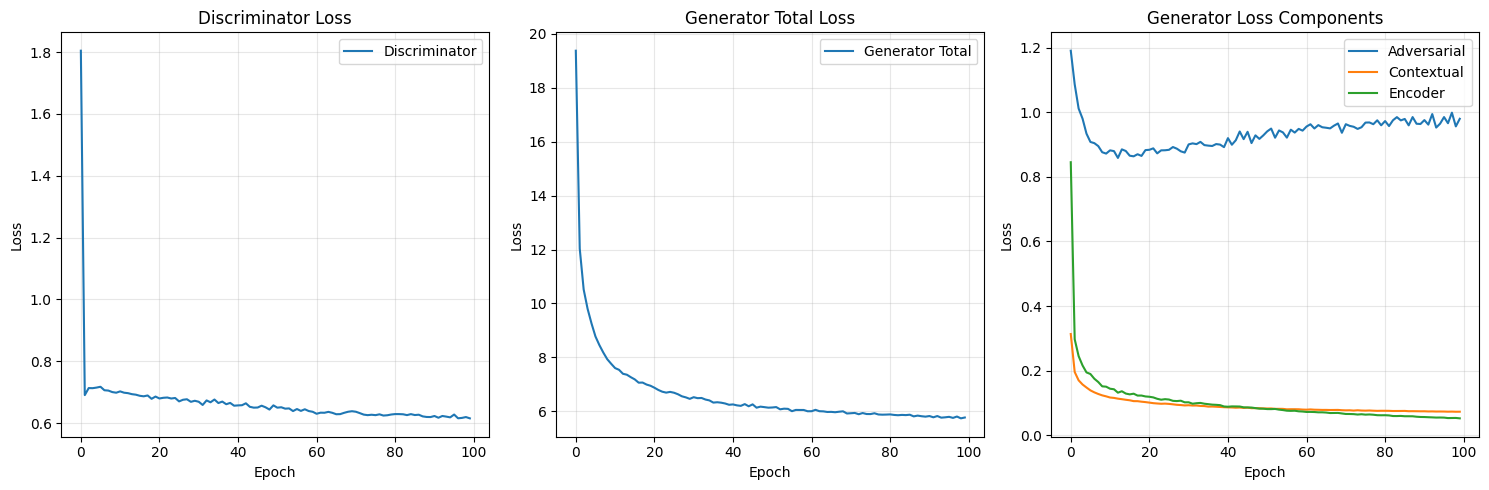

In [ ]:
# 손실 그래프 시각화

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_history['D'], label='Discriminator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(loss_history['G'], label='Generator Total')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Total Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(loss_history['G_adv'], label='Adversarial')
plt.plot(loss_history['G_con'], label='Contextual')
plt.plot(loss_history['G_enc'], label='Encoder')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Generator Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# XAI 기능 - 얼굴 부위 탐지 클래스

class FaceRegionDetector:
    def __init__(self):
        # MediaPipe 대신 간단한 그리드 기반 탐지 사용
        # self.mp_face_mesh = mp.solutions.face_mesh
        # self.face_mesh = self.mp_face_mesh.FaceMesh(...)
        pass

        # 얼굴 부위별 랜드마크 인덱스 정의 (참고용)
        # 실제로는 get_region_masks에서 그리드 기반 사용
        self.regions = {
            '왼쪽 눈': 'grid-based',
            '오른쪽 눈': 'grid-based',
            '코': 'grid-based',
            '입': 'grid-based',
            '턱': 'grid-based',
            '이마': 'grid-based',
        }

    def get_region_masks(self, image_size):
        """얼굴 부위별 마스크 생성 (간단한 그리드 기반)"""
        h, w = image_size
        masks = {}

        # 간단한 그리드 기반 마스크 (MediaPipe 없이도 동작)
        masks['왼쪽 눈'] = np.zeros((h, w), dtype=np.uint8)
        masks['오른쪽 눈'] = np.zeros((h, w), dtype=np.uint8)
        masks['코'] = np.zeros((h, w), dtype=np.uint8)
        masks['입'] = np.zeros((h, w), dtype=np.uint8)
        masks['턱'] = np.zeros((h, w), dtype=np.uint8)
        masks['이마'] = np.zeros((h, w), dtype=np.uint8)

        # 대략적인 얼굴 부위 영역 설정
        masks['왼쪽 눈'][int(h*0.3):int(h*0.5), int(w*0.2):int(w*0.4)] = 1
        masks['오른쪽 눈'][int(h*0.3):int(h*0.5), int(w*0.6):int(w*0.8)] = 1
        masks['코'][int(h*0.4):int(h*0.65), int(w*0.4):int(w*0.6)] = 1
        masks['입'][int(h*0.65):int(h*0.85), int(w*0.3):int(w*0.7)] = 1
        masks['턱'][int(h*0.75):int(h*0.95), int(w*0.35):int(w*0.65)] = 1
        masks['이마'][int(h*0.1):int(h*0.35), int(w*0.25):int(w*0.75)] = 1

        return masks

In [ ]:
# XAI 시각화 함수

def create_heatmap(error_map):
    """에러 맵을 히트맵으로 변환"""
    error_normalized = (error_map - error_map.min()) / (error_map.max() - error_map.min() + 1e-8)
    heatmap = cv2.applyColorMap((error_normalized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    return heatmap

def analyze_face_regions(error_map, region_detector):
    """얼굴 부위별 이상 점수 계산"""
    h, w = error_map.shape
    masks = region_detector.get_region_masks((h, w))

    region_scores = {}
    for region_name, mask in masks.items():
        if mask.sum() > 0:
            region_error = error_map * mask
            region_scores[region_name] = region_error.sum() / mask.sum()
        else:
            region_scores[region_name] = 0.0

    return region_scores

def visualize_detection(original, reconstructed, error_map, region_scores,
                       anomaly_score, threshold, save_path=None):
    """탐지 결과 시각화"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 원본 이미지
    axes[0, 0].imshow(original)
    axes[0, 0].set_title('원본 이미지', fontsize=14, fontweight='bold')
    axes[0, 0].axis('off')

    # 복원 이미지
    axes[0, 1].imshow(reconstructed)
    axes[0, 1].set_title('복원 이미지', fontsize=14, fontweight='bold')
    axes[0, 1].axis('off')

    # 차이 맵
    diff = np.abs(original.astype(float) - reconstructed.astype(float)).mean(axis=2)
    axes[0, 2].imshow(diff, cmap='hot')
    axes[0, 2].set_title('차이 맵', fontsize=14, fontweight='bold')
    axes[0, 2].axis('off')

    # 히트맵
    heatmap = create_heatmap(error_map)
    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    axes[1, 0].imshow(heatmap_rgb)
    axes[1, 0].set_title('이상 감지 히트맵', fontsize=14, fontweight='bold')
    axes[1, 0].axis('off')

    # 오버레이
    overlay = cv2.addWeighted(original, 0.6, heatmap_rgb, 0.4, 0)
    axes[1, 1].imshow(overlay)

    is_fake = anomaly_score > threshold
    detection_text = "딥페이크 감지" if is_fake else "정상"
    color = 'red' if is_fake else 'green'
    axes[1, 1].set_title(f'{detection_text} (의심도: {anomaly_score:.1f}%)',
                         fontsize=14, fontweight='bold', color=color)
    axes[1, 1].axis('off')

    # 부위별 분석 결과
    axes[1, 2].axis('off')
    sorted_regions = sorted(region_scores.items(), key=lambda x: x[1], reverse=True)

    analysis_text = f"=== 탐지 결과 ===\n\n"
    analysis_text += f"전체 의심도: {anomaly_score:.1f}%\n"
    analysis_text += f"판정: {detection_text}\n\n"
    analysis_text += "=== 부위별 분석 ===\n\n"

    for region, score in sorted_regions[:5]:
        percentage = score * 100
        if percentage > 30:
            status = "합성 의심"
        elif percentage > 15:
            status = "주의 필요"
        else:
            status = "정상"
        analysis_text += f"{region}: {percentage:.1f}% {status}\n"

    axes[1, 2].text(0.1, 0.5, analysis_text, fontsize=12, verticalalignment='center',
                    family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()

    # 콘솔 출력
    print(f"\n{'='*60}")
    print(f"탐지 결과: {detection_text}")
    print(f"딥페이크 의심도: {anomaly_score:.1f}%")
    print(f"{'='*60}")
    print("\n부위별 상세 분석:")
    for region, score in sorted_regions:
        percentage = score * 100
        bar = '█' * int(percentage / 5)
        print(f"  {region:12s}: {percentage:5.1f}% {bar}")
        if percentage > 30:
            print(f"             → {region} 부분 합성이 강하게 의심됩니다.")
        elif percentage > 15:
            print(f"             → {region} 부분에 주의가 필요합니다.")
    print(f"{'='*60}\n")

In [ ]:
# 평가 및 XAI 분석

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support

netG.eval()
netD.eval()

all_labels = []
all_scores = []

print("평가 시작")
with torch.no_grad():
    for images, labels, _ in tqdm(test_loader, desc="평가 진행 중"):
        images = images.to(config.DEVICE)

        fake_images, latent_i, latent_o = netG(images)

        # Anomaly score 계산
        error_recon = torch.mean(torch.abs(images - fake_images), dim=[1, 2, 3])
        error_latent = torch.mean((latent_i - latent_o) ** 2, dim=[1, 2, 3])
        anomaly_score = error_recon + 0.1 * error_latent

        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(anomaly_score.cpu().numpy())

# ROC AUC 계산
auc = roc_auc_score(all_labels, all_scores)
print(f"\n>> 최종 탐지 성능 (ROC AUC): {auc:.4f}")

if auc < 0.5:
    print("\n[경고] AUC < 0.5 감지 -> Score를 반전합니다.")
    all_scores = [-s for s in all_scores]
    auc = roc_auc_score(all_labels, all_scores)
    print(f">> 수정된 ROC AUC: {auc:.4f}")

# 임계값 찾기
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Score를 0-100% 범위로 정규화 (Percentile 방식 - 더 robust)
score_5th = np.percentile(all_scores, 5)   # 하위 5%ile
score_95th = np.percentile(all_scores, 95)  # 상위 95%ile
score_min = score_5th  # 하위호환성을 위해 유지
score_max = score_95th

print(f"\n[정규화 범위] 5%ile: {score_5th:.4f}, 95%ile: {score_95th:.4f}")
print(f"[참고] 실제 Min: {min(all_scores):.4f}, Max: {max(all_scores):.4f}")

all_scores_normalized = [
    np.clip((s - score_5th) / (score_95th - score_5th + 1e-8) * 100, 0, 100)
    for s in all_scores
]
threshold_normalized = np.clip(
    (optimal_threshold - score_5th) / (score_95th - score_5th + 1e-8) * 100,
    0, 100
)

predictions = (np.array(all_scores) > optimal_threshold).astype(int)

# 성능 계산
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, predictions)
accuracy = accuracy_score(all_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, predictions, average='binary')

print(f"\n>> Confusion Matrix:")
print(f"TN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
print(f"\n>> 최적 임계값: {threshold_normalized:.1f}%")
print(f">> 정확도: {accuracy:.4f}")
print(f">> 정밀도: {precision:.4f}")
print(f">> 재현율: {recall:.4f}")
print(f">> F1 Score: {f1:.4f}")
print(f"\n>> 클래스별 성능:")
print(f"Real 탐지율: {cm[0,0]/(cm[0,0]+cm[0,1]):.4f}")
print(f"Fake 탐지율: {cm[1,1]/(cm[1,0]+cm[1,1]):.4f}")

평가 시작


평가 진행 중: 100%|██████████| 82/82 [00:10<00:00,  7.66it/s]


>> 최종 탐지 성능 (ROC AUC): 0.9830

[정규화 범위] 5%ile: 0.0573, 95%ile: 0.2490
[참고] 실제 Min: 0.0319, Max: 0.3929

>> Confusion Matrix:
TN: 1093, FP: 86
FN: 58, TP: 1383

>> 최적 임계값: 38.3%
>> 정확도: 0.9450
>> 정밀도: 0.9415
>> 재현율: 0.9598
>> F1 Score: 0.9505

>> 클래스별 성능:
Real 탐지율: 0.9271
Fake 탐지율: 0.9598


XAI 분석을 시작합니다...


/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipyth

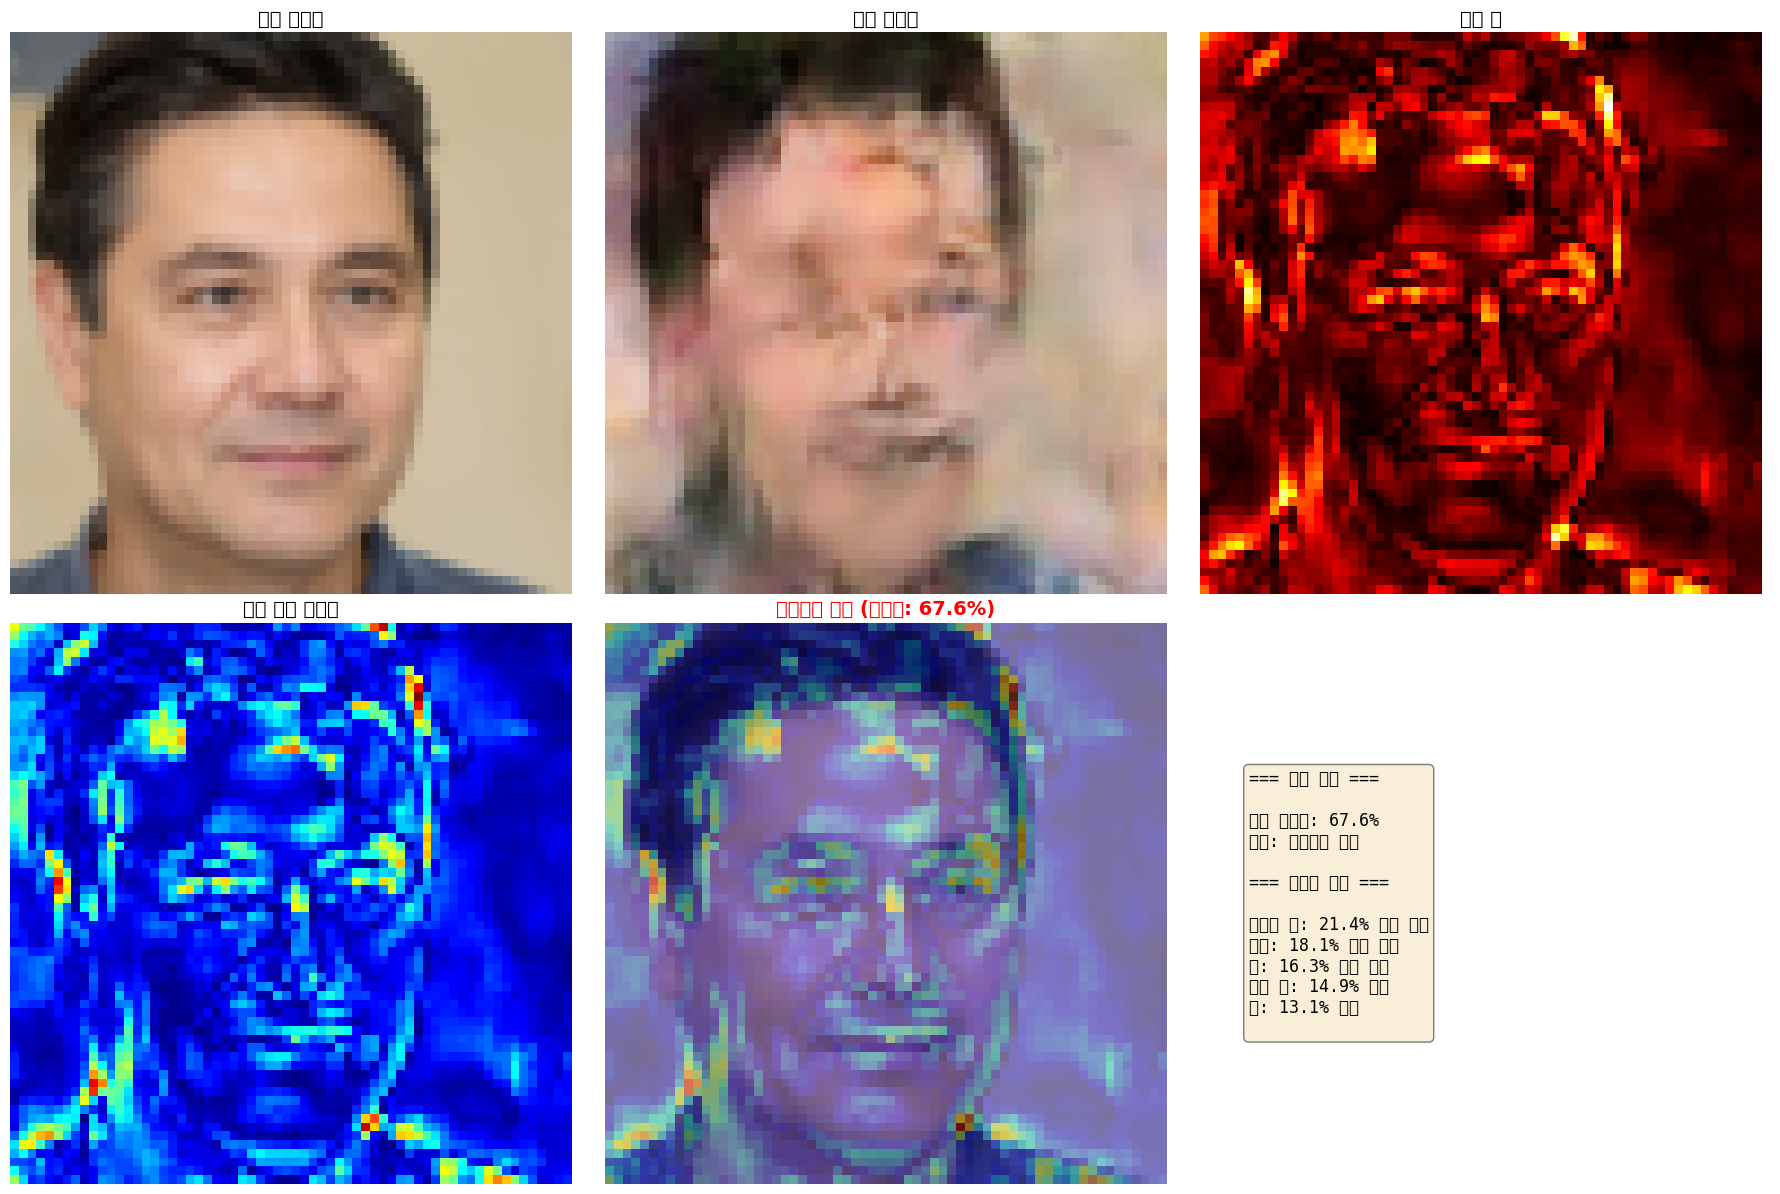


탐지 결과: 딥페이크 감지
딥페이크 의심도: 67.6%

부위별 상세 분석:
  오른쪽 눈       :  21.4% ████
             → 오른쪽 눈 부분에 주의가 필요합니다.
  이마          :  18.1% ███
             → 이마 부분에 주의가 필요합니다.
  코           :  16.3% ███
             → 코 부분에 주의가 필요합니다.
  왼쪽 눈        :  14.9% ██
  입           :  13.1% ██
  턱           :  11.5% ██



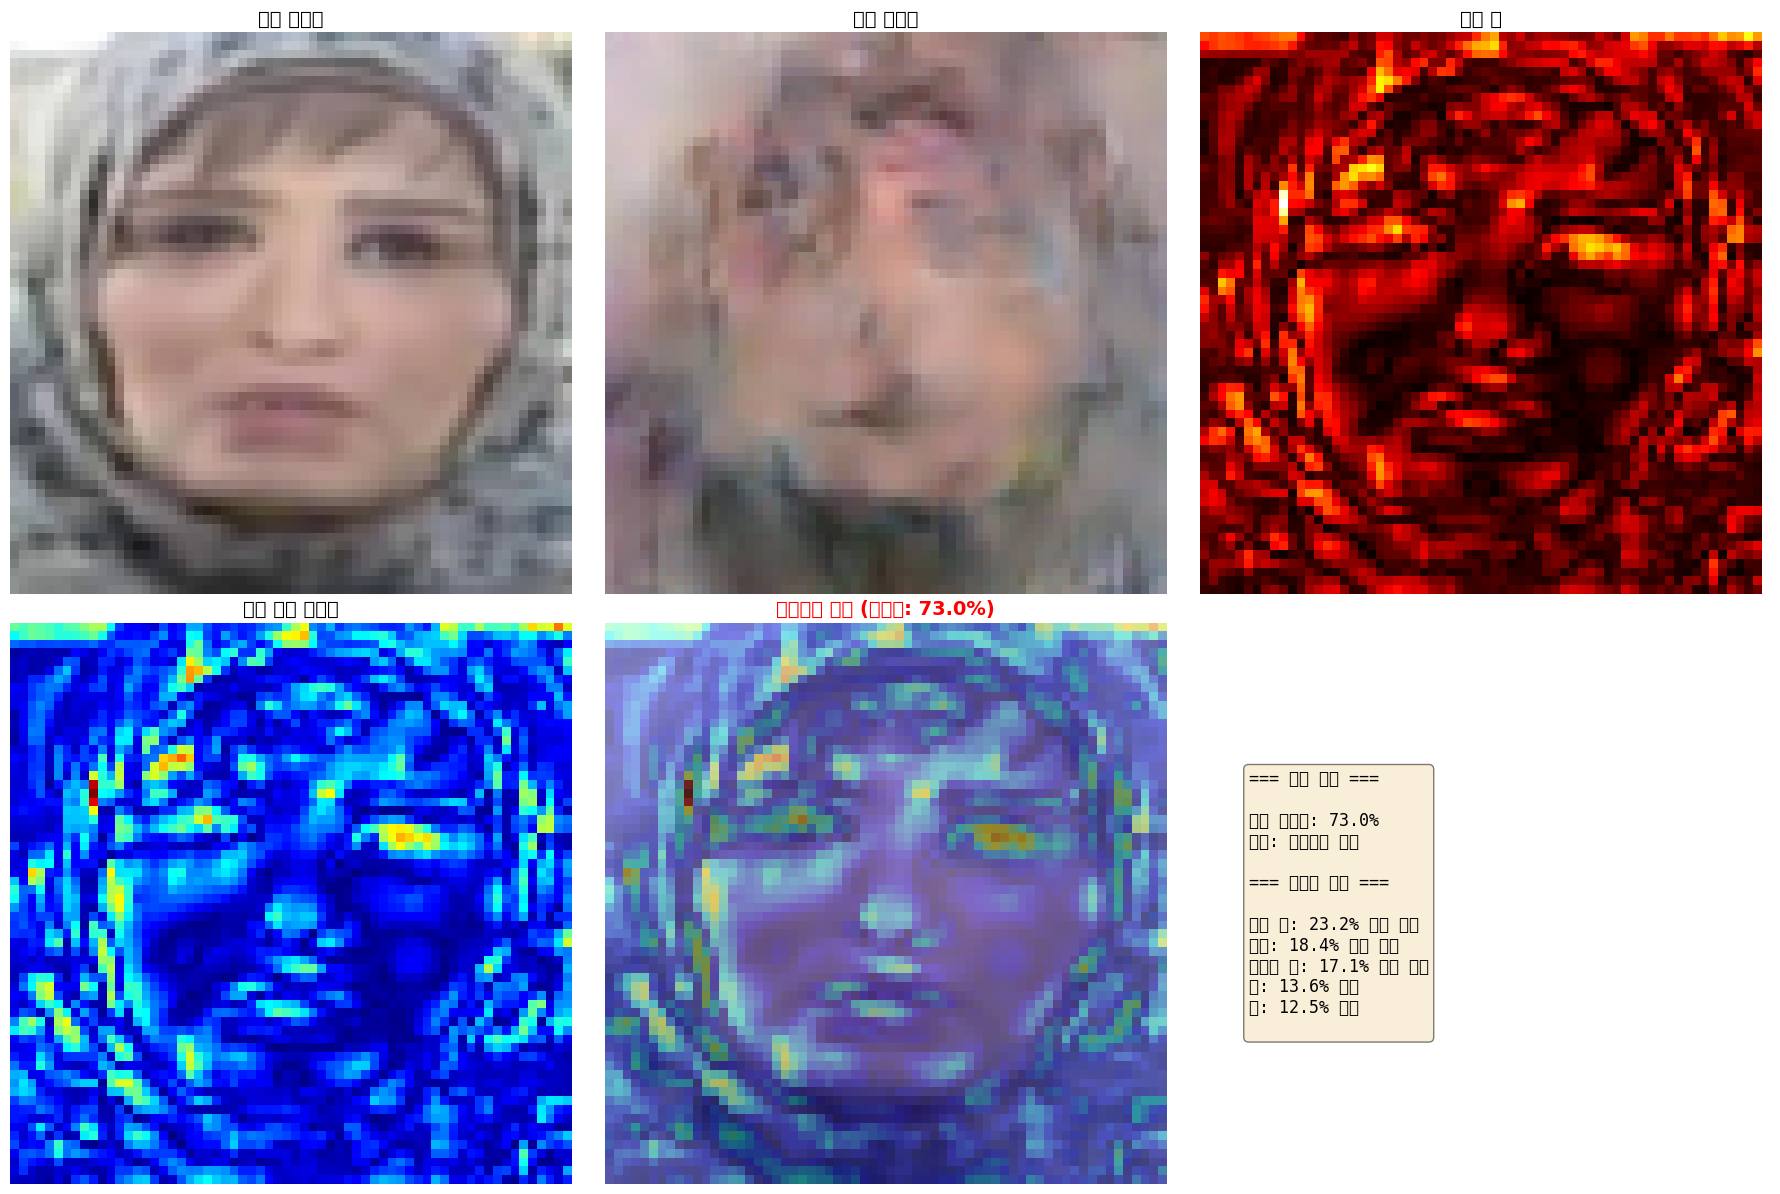


탐지 결과: 딥페이크 감지
딥페이크 의심도: 73.0%

부위별 상세 분석:
  왼쪽 눈        :  23.2% ████
             → 왼쪽 눈 부분에 주의가 필요합니다.
  이마          :  18.4% ███
             → 이마 부분에 주의가 필요합니다.
  오른쪽 눈       :  17.1% ███
             → 오른쪽 눈 부분에 주의가 필요합니다.
  코           :  13.6% ██
  입           :  12.5% ██
  턱           :  12.0% ██



/tmp/ipython-input-107353875.py:85: UserWarning: Glyph 53553 (\N{HANGUL SYLLABLE TEOG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-107353875.py:88: UserWarning: Glyph 53553 (\N{HANGUL SYLLABLE TEOG}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53553 (\N{HANGUL SYLLABLE TEOG}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


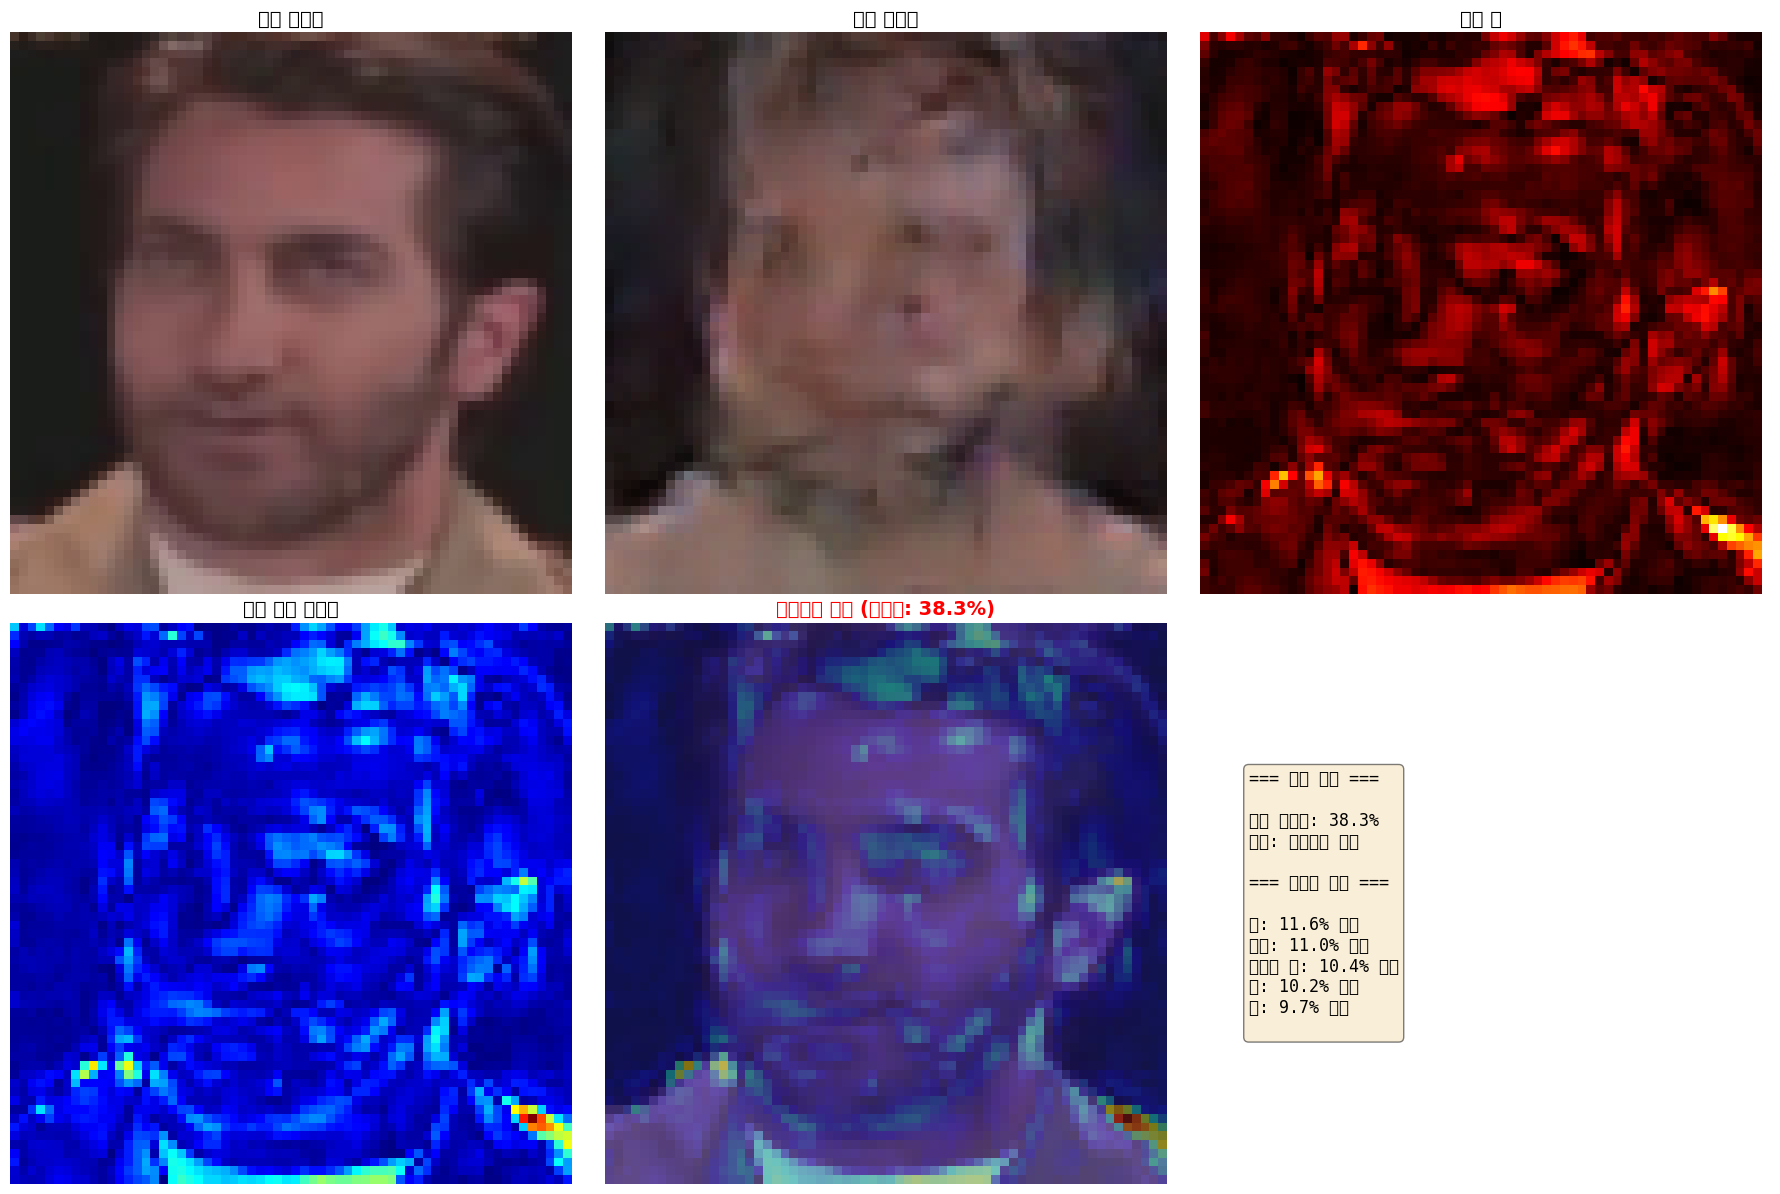


탐지 결과: 딥페이크 감지
딥페이크 의심도: 38.3%

부위별 상세 분석:
  코           :  11.6% ██
  이마          :  11.0% ██
  오른쪽 눈       :  10.4% ██
  턱           :  10.2% ██
  입           :   9.7% █
  왼쪽 눈        :   8.3% █



In [ ]:
# XAI 시각화 - 샘플 분석

print("XAI 분석을 시작합니다...")

region_detector = FaceRegionDetector()

def denormalize(tensor):
    return tensor * 0.5 + 0.5

# 딥페이크 샘플 3개 선택하여 상세 분석
fake_analyzed = 0
for images, labels, paths in test_loader:
    for i in range(len(labels)):
        if labels[i] == 1 and fake_analyzed < 3:  # 딥페이크만 분석
            image = images[i:i+1].to(config.DEVICE)

            with torch.no_grad():
                fake_image, latent_i, latent_o = netG(image)

                # Error map 계산
                error_map_3d = torch.abs(image - fake_image)
                error_map_2d = error_map_3d.mean(dim=1).squeeze().cpu().numpy()

                # Anomaly score
                error_recon = torch.mean(torch.abs(image - fake_image), dim=[1, 2, 3])
                error_latent = torch.mean((latent_i - latent_o) ** 2, dim=[1, 2, 3])
                anomaly_score_raw = (error_recon + 0.1 * error_latent).item()

                # 정규화된 의심도 (0-100% 범위로 제한)
                anomaly_score_norm = (anomaly_score_raw - score_min) / (score_max - score_min) * 100
                anomaly_score_norm = np.clip(anomaly_score_norm, 0, 100)  # 100% 초과 방지!

            # 이미지 변환
            original_np = (denormalize(image).squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
            reconstructed_np = (denormalize(fake_image).squeeze().permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

            # 부위별 분석
            region_scores = analyze_face_regions(error_map_2d, region_detector)

            # 시각화
            visualize_detection(
                original_np,
                reconstructed_np,
                error_map_2d,
                region_scores,
                anomaly_score_norm,
                threshold_normalized,
                save_path=f'/content/drive/MyDrive/xai_result_{fake_analyzed+1}.png'
            )

            fake_analyzed += 1

    if fake_analyzed >= 3:
        break

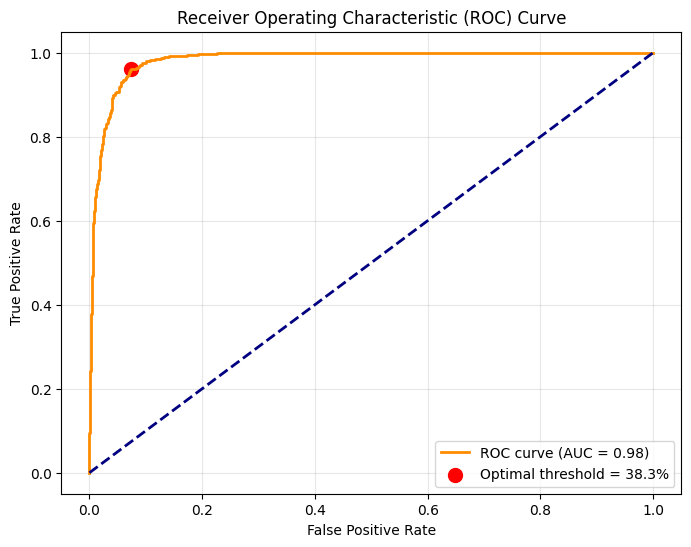

In [ ]:
# ROC 곡선 시각화

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], c='red', s=100,
            label=f'Optimal threshold = {threshold_normalized:.1f}%')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 모델 저장

print("\n>> 모델을 구글 드라이브에 저장합니다...")
torch.save({
    'generator': netG.state_dict(),
    'discriminator': netD.state_dict(),
    'config': config,
    'auc': auc,
    'optimal_threshold': optimal_threshold,
    'threshold_normalized': threshold_normalized,
    'score_min': score_min,  # score_5th와 동일
    'score_max': score_max,  # score_95th와 동일
    'score_5th': score_5th,  # Percentile 값 저장
    'score_95th': score_95th,  # Percentile 값 저장
    'loss_history': loss_history,
}, '/content/drive/MyDrive/GANomaly_deepfake_xai_model.pth')


print(">> 모든 작업 완료")
print(f">> 최종 ROC AUC: {auc:.4f}")
print(f">> 탐지 임계값: {threshold_normalized:.1f}%")
print(f">> 모델 저장 위치: /content/drive/MyDrive/ganomaly_deepfake_xai_model.pth")
print(f">> XAI 결과 이미지: /content/drive/MyDrive/xai_result_*.png")


>> 모델을 구글 드라이브에 저장합니다...
>> 모든 작업 완료
>> 최종 ROC AUC: 0.9830
>> 탐지 임계값: 38.3%
>> 모델 저장 위치: /content/drive/MyDrive/ganomaly_deepfake_xai_model.pth
>> XAI 결과 이미지: /content/drive/MyDrive/xai_result_*.png
